<h3>You should check out those great videos made by the brillient <a href="https://www.youtube.com/@3blue1brown">3blue1brown</a></h3>

<table style="width:50%">
  <tr>
    <th>Description</th>
    <th>Video Link</th>
  </tr>
  <tr>
      <td>
        How the Fourier Transform works
     </td>
    <td>
        <a href="https://www.youtube.com/watch?v=spUNpyF58BY/">
           <img alt="Qries" src="images/video cover 1.jpg">
        </a>
     </td>
  </tr>
    <tr>
    <td>
        More interesting uses
     </td>
    <td>
        <a href="https://www.youtube.com/watch?v=r6sGWTCMz2k&t=118s">
           <img alt="Qries" src="images/video cover 2.jpg">
        </a>
     </td>
  </tr>
</table>
                                                                  
                                                                 

In [2]:
from AudioParamersExtraction import *

## Load and cut a sample of A2 guitar string audio

In [3]:
sound_array, sr = librosa.load('sounds/A2.mp3')
sound_array, _ = librosa.effects.trim(sound_array)

In [4]:
# Length of a sample
N = 30_000
# Starting point of this example
start = 0
# The duration of this sample in seconds
DURATION = N/sr

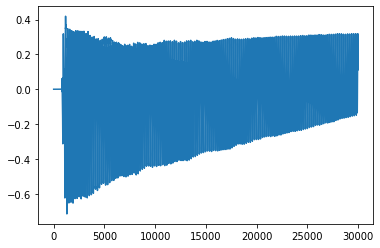

In [5]:
# Show the sound wave
sub_array = sound_array[start:start+N]
plt.plot(sub_array)

# Play the original audio
sd.play(sub_array, sr)

### Apply the fft and calculate the magnitude
> - The output of fft is an array of *complex* numbers<br>
> - But the magnitudes are *real positive* numbers<br>
**So we'll take the absolute values**

In [6]:
sound_array_fft = np.fft.fft(sub_array)
magnitude_spectrum = np.abs(sound_array_fft)

### show the frequencies

Text(0, 0.5, 'magnitude')

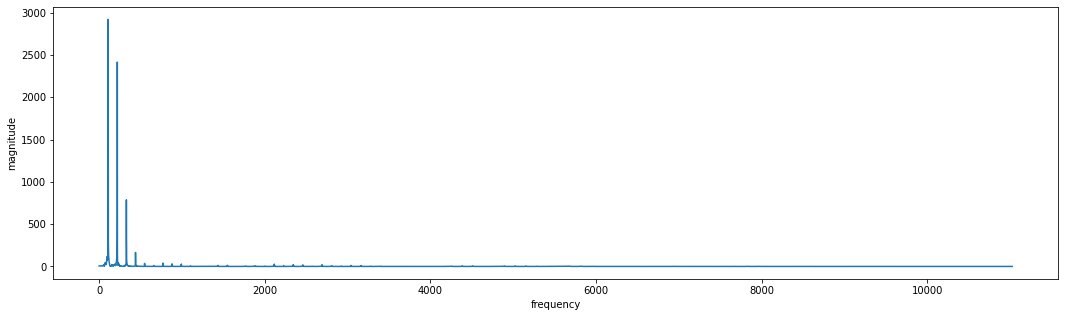

In [7]:
freqs = np.linspace(0, sr, len(magnitude_spectrum))

f_ratio = 0.5
num_bins = int(len(freqs) * f_ratio)

part_freqs = freqs[:num_bins]
part_magnitude_spectrum = magnitude_spectrum[:num_bins]

plt.figure(figsize=(18, 5))
plt.plot(part_freqs, part_magnitude_spectrum)
plt.xlabel('frequency')
plt.ylabel('magnitude')

### Get the estimated values of the picks from the graph

Text(0, 0.5, 'magnitude')

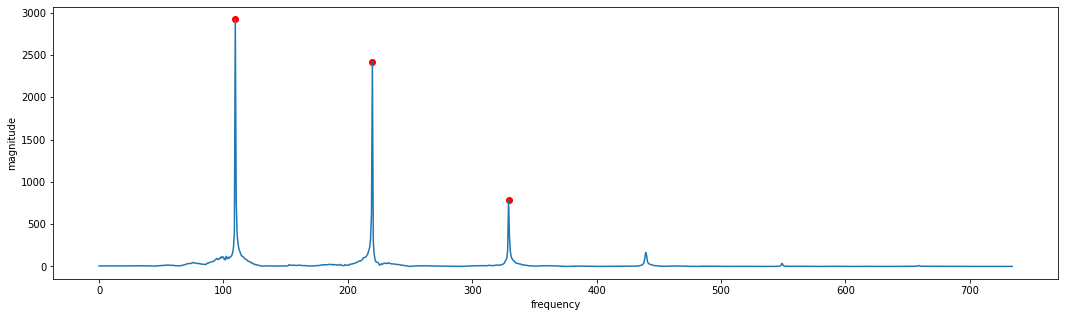

In [8]:
predicted_freqs, predicted_mag = predict_freqs_and_magnitudes(part_magnitude_spectrum, part_freqs)

plt.figure(figsize=(18, 5))
plt.scatter(predicted_freqs, predicted_mag, c='r')
plt.plot(part_freqs[:1000], part_magnitude_spectrum[:1000])
plt.xlabel('frequency')
plt.ylabel('magnitude')

## Oprimizing the amplitudes
> In order to improve our prediction I'll use the *Least Squares* algorithm.<br>
#### The Variables
> - **X** is a matrix of the diffrent waves created as a sine waves from the predicted frequencies:
>> - Each column of X is a diffrent single wave.
>> - Each row of X is a vector with the values of the waves in a single moment.
> - **y** is the vector of the original wave.
> - **a** is a vector of predicted amplitudes

$$
X\underline{\mathbf{a}}=\underline{\mathbf{y}}
$$

$$
\begin{pmatrix}
    \begin{bmatrix} x_{1,1} & ... & x_{1,k} \end{bmatrix} \\
    ⋮ \\
    ⋮ \\
    \begin{bmatrix} x_{N,1} & ... & x_{N,k} \end{bmatrix}
\end{pmatrix}
\begin{bmatrix} amp_1 \\ 
    ⋮ \\
    amp_k
\end{bmatrix}=
\begin{bmatrix} y_1 \\
    ⋮ \\
    ⋮ \\
    y_N
\end{bmatrix}
$$

In [12]:
# define amp_vector0
amp_vector0 = predicted_mag/N

# define X
sine_waves_list = [get_sine_wave(f, DURATION, sample_rate=sr, amplitude=amp)
                   for f, amp in zip(predicted_freqs, amp_vector0)]

X = np.array(sine_waves_list)
X = X.transpose()

# define y
y = sub_array

#### Add a bias variable and a coresponding column to X
This might helps as to fit our parameters better.
> Note that the target vector **y** hasn't change!

$$
\begin{pmatrix}
    \begin{bmatrix} 1 & x_{1,1} & ... & x_{1,k} \end{bmatrix} \\
    ⋮ \\
    ⋮ \\
    \begin{bmatrix} 1 & x_{N,1} & ... & x_{N,k} \end{bmatrix}
\end{pmatrix}
\begin{bmatrix}
    1 \\
    amp_1 \\ 
    ⋮ \\
    amp_k
\end{bmatrix}=
\begin{bmatrix} y_1 \\
    ⋮ \\
    ⋮ \\
    y_N
\end{bmatrix}
$$

In [13]:
X = np.c_[np.ones(N), X]
amp_vector0 = np.r_[1, amp_vector0]

#### Finaly we'll use the **scipy.optimize.curve_fit** function to calculate the optimal amplitudes

In [14]:
popt, pcov = curve_fit(calculate_wave, X, y, amp_vector0)
popt

array([ 2.00170711e-04, -1.19152916e+00, -1.68208377e+00, -1.78319989e+00])

## Let's check the wave that we predicted!

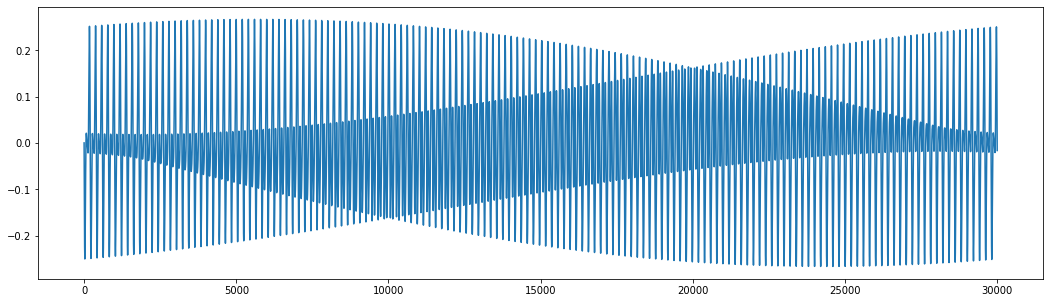

In [15]:
y_pred = X.dot(popt)

sd.play(y_pred, sr)
plt.figure(figsize=(18, 5))
plt.plot(y_pred)

#### For comparison we will show the graph and hear the sound of a single A2 note

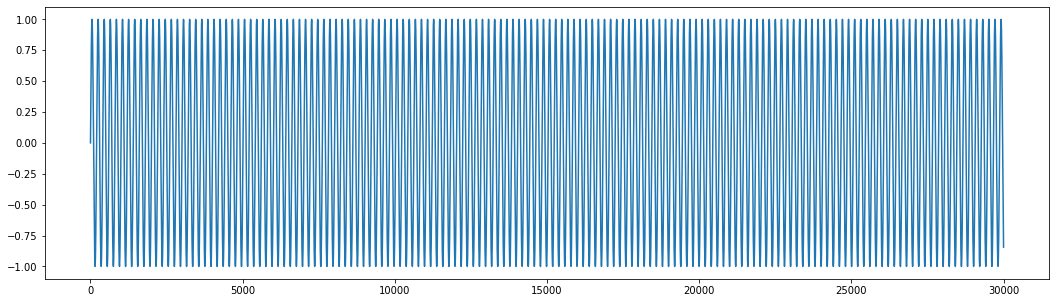

In [16]:
example_A2_sine_wave = get_sine_wave(NOTES_FREQS['A2'], DURATION, sr, 1)
sd.play(example_A2_sine_wave, sr)
plt.figure(figsize=(18, 5))
plt.plot(example_A2_sine_wave)

## Now as a single function

In [27]:
def predict_wave_freqs_magnitudes(sound_array: np.array, sr: int, duration: float, N: int):
    sound_array_fft = np.fft.fft(sound_array)
    magnitude_spectrum = np.abs(sound_array_fft)
    freqs = np.linspace(0, sr, len(magnitude_spectrum))

    predicted_freqs, predicted_mag = predict_freqs_and_magnitudes(magnitude_spectrum, freqs)

    sine_waves_list = [get_sine_wave(f, duration, sample_rate=sr, amplitude=m/N)
                       for f, m in zip(predicted_freqs, predicted_mag)]

    X = np.array(sine_waves_list)
    X = X.transpose()
    p0 = np.array(predicted_mag)
    
    popt, pcov = curve_fit(calculate_wave, X, sound_array, p0)

    sound_array_pred = X.dot(popt)
    
    return sound_array_pred, predicted_freqs, predicted_mag

In [28]:
sound_array_pred, predicted_freqs, predicted_mag = predict_wave_freqs_magnitudes(sub_array, sr, DURATION, N)
sd.play(sound_array_pred, sr)

In [23]:
# Again, this is a A2 sine wave calaulated from formula
sd.play(get_sine_wave(NOTES_FREQS['A2'], DURATION, sr, 1), sr)

### Another example with A2 and E2 notes together

In [24]:
sound_array_a, sr = librosa.load('sounds/A2.mp3')
sound_array_a, _ = librosa.effects.trim(sound_array_a)

sound_array_e, sr = librosa.load('sounds/E2.mp3')
sound_array_e, _ = librosa.effects.trim(sound_array_e)

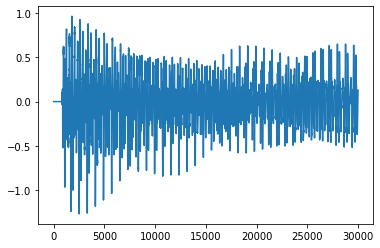

In [25]:
sub_array = sound_array_a[start:start+N] + sound_array_e[start:start+N]
plt.plot(sub_array)
sd.play(sub_array, sr)

In [26]:
sound_array_pred, predicted_freqs, predicted_mag = predict_wave_freqs_magnitudes(sub_array, sr, DURATION)
sd.play(sound_array_pred, sr)

<h3>You should also check out the following video for better understanding</h3>

<table style="width:50%">
    <td>
        <a href="https://www.youtube.com/watch?v=mQzJ_1Rj6qo">
           <img alt="Qries" src="images/video cover 3.jpg">
        </a>
     </td>
  </tr>
</table>
                                                                  
                                                                 